# Effective Area Plotting Example
Author: Michael Larson
Last Update: 24 January 2024

This repository is intended to serve as an example for anyone who needs to build an effective area 
curve. This script is a minimal working example used to extract information from i3 files generated 
by neutrino-generator or GENIE.


In [1]:
import os, sys, glob
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import numpy.lib.recfunctions as rf

# Wrap the plotting for effective area
There's some specific factors that need to be included when plotting an effective area. Wrap it all in a function for clarity.

In [10]:
def make_aeff(ax, x, 
              ebins = np.logspace(0, 5, 101), 
              dec_range = [-np.pi/2, np.pi/2],
              **kwargs):
        
    # Mask the events to the correct range of declinations or zeniths
    (dec_min, dec_max) = dec_range
    mask = (dec_min <= x['trueDec']) & (x['trueDec'] < dec_max)
        
    # Histogram the 'oneweight' values. This will give us a histogram
    # in the same units as 'ow', which means we'll have `GeV cm2 sr`
    # after this step. 
    h, b = np.histogram(x['trueE'][mask],
                        weights = x['ow'][mask],
                        bins=ebins)
    print(mask.sum())

    # Now account for the phase space, which will reduce us from
    # `GeV cm2 sr` to `cm2`
    h /= np.diff(b)
    h /= 2*np.pi
    h /= (np.sin(x['trueDec'][mask].max()) - np.sin(x['trueDec'][mask].min()))
    
    # And now we're finally at an effective area curve!
    # It's currently in cm^2. Convert it to m^2
    h /= 1e4 

    # Now plot it onto the axis and return.
    _ = ax.hist(b[:-1],
                bins = b,
                weights = h,
                **kwargs)
    return

## Load our input files. 
Here I'm assuming that we have a numpy structured array. This acts like a dictionary or a pandas dataframe
with fields ['trueZen', 'trueDec', 'ow', 'trueE']. 

NOTE: NuSources datasets have an extra factor of 2 included since fluxes
      are given in terms of nu+nubar instead of separately, which is what
      IceCube OneWeights are designed for. In order to make these comparisons
      fair when comparing to NuSources datasets, we need to add the factor
      of 2. This factor is included in NuSources files in conversion scripts 
      like the "QUESO" version here: 
      https://github.com/mjlarson/nusources_dataset_converters/blob/main/convert_upgrade_queso.py#L182-L187

In [55]:
def load_queso():
    queso = [np.load("./queso_140028.npy"),
             np.load("./queso_140128.npy")]
    queso = np.concatenate(queso)
    queso['ow'] /= 2
    return queso

def load_upgrade_trigger():
    upgrade_trigger = [np.load("./upgrade_trigger_140028.npy"),
                       np.load("./upgrade_trigger_140128.npy")]
    upgrade_trigger = np.concatenate(upgrade_trigger)
    upgrade_trigger['ow'] /= 2
    return upgrade_trigger

def load_deepcore_filter():
    dcfilter = np.load("./deepcore_filter_140000.npy")
    dcfilter['ow'] /= 2
    return dcfilter

def load_oscnext():
    oscnext = np.load("./oscnext_140000.npy")
    oscnext['ow'] /= 2
    return oscnext

In [56]:
datasets = {'IceCube Upgrade (Trigger)': load_upgrade_trigger(),
            'IceCube Upgrade (QUESO))': load_queso(),
            'IceCube DeepCore (DeepCoreFilter)': load_deepcore_filter(),
            'IceCube DeepCore (OscNext)': load_oscnext()}

## Make a plot with effective area averaged over the full sky

95904
43979
573801
304651


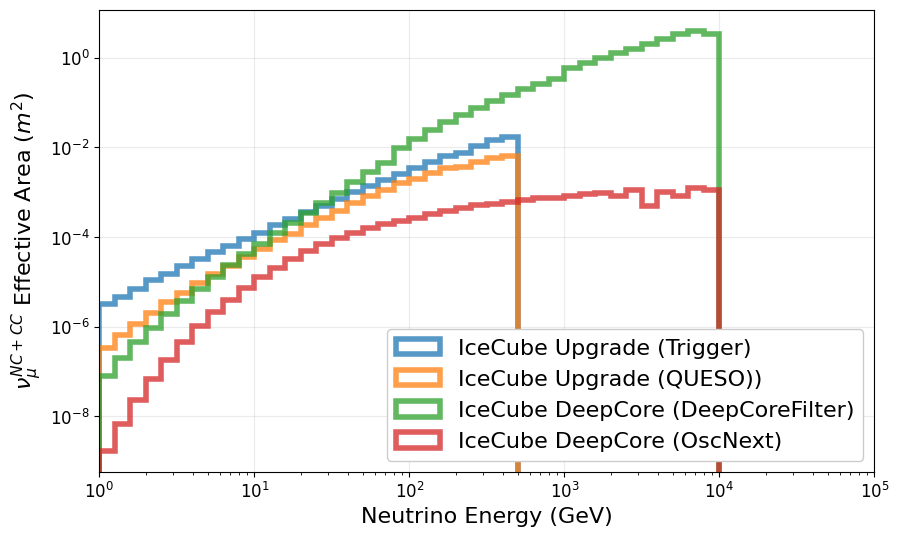

In [57]:
##################################################
# Plot everything in "datasets" without extra cuts
##################################################
fig, ax = plt.subplots(figsize=(10,6))
ebins = np.logspace(0, 5, 51)

for label, data in datasets.items():
    make_aeff(ax, data, ebins, 
              histtype='step',
              linewidth=4,
              linestyle = 'solid',
              alpha=0.75,
              label=label)

ax.grid(alpha=0.25)
ax.set_xlim(ebins.min(), ebins.max())
ax.set_xscale('log')
ax.tick_params(labelsize=12)
ax.set_yscale('log')
ax.legend(loc='lower right', fontsize=16, framealpha = 1,)
ax.set_xlabel("Neutrino Energy (GeV)", fontsize=16)
ax.set_ylabel(r"$\nu_\mu^{NC+CC}$ Effective Area ($m^2$)", fontsize=16)
fig.savefig("oscnext_greco_aeff.pdf")

## And one with effective areas broken out into several bins for one of the individual datasets

99282
155549
49820


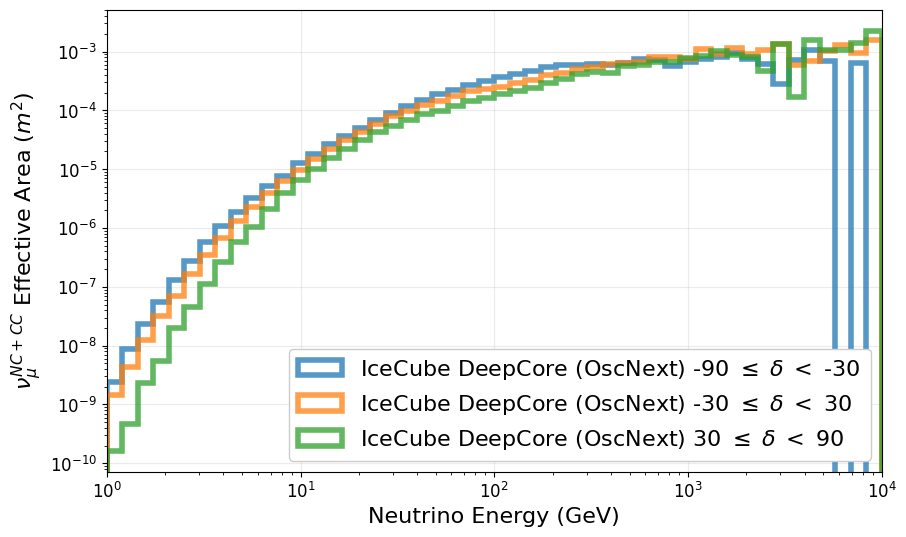

In [60]:
##################################################
# Plot GRECO effective area in declination bins
##################################################
fig, ax = plt.subplots(figsize=(10,6))
ebins = np.logspace(0, 4, 51)
dec_bins = [-90, -30, 30, 90]

label = 'IceCube DeepCore (OscNext)'
data = datasets[label]

for dec_min, dec_max in zip(dec_bins[:-1], dec_bins[1:]):
    make_aeff(ax, data, ebins,
              dec_range = np.radians([dec_min, dec_max]),
              histtype='step',
              linewidth=4,
              linestyle = 'solid',
              alpha=0.75,
              label = label + fr" {dec_min} $\leq\;\delta\;<$ {dec_max} ")

ax.grid(alpha=0.25)
ax.set_xlim(ebins.min(), ebins.max())
ax.set_xscale('log')
ax.tick_params(labelsize=12)
ax.set_yscale('log')
ax.legend(loc='lower right', fontsize=16, framealpha = 1,)
ax.set_xlabel("Neutrino Energy (GeV)", fontsize=16)
ax.set_ylabel(r"$\nu_\mu^{NC+CC}$ Effective Area ($m^2$)", fontsize=16)
fig.savefig("oscnext_aeff.pdf")